In [52]:
import numpy as np
import itertools
from matplotlib import pyplot as plt
from matplotlib import colors, colormaps, cm


# Actions
LEFT = (-1, 0)
RIGHT = (1, 0)
TOP = (0, -1)
DOWN = (0, 1)
# Action Names (used for plotting)
action_names = {
    LEFT: "←",
    RIGHT: "→",
    TOP: "↑",
    DOWN: "↓"
}


In [53]:
class GridWorld():
    def __init__(self, size, goal):
        self.size = size
        self.states = list(np.ndindex(size))
        self.rewards = dict(zip(self.states, itertools.repeat(-0.1)))
        self.rewards[goal] = 1
        self.goal = goal
        self.actions = [LEFT, RIGHT, TOP, DOWN]
        # initialize deterministic policy
        self.dynamics = {start: {action: {tuple(
            np.add(start, action)): 1} for action in self.actions} for start in self.states}
        for x in range(size[0]):
            self.dynamics[(x, 0)][TOP] = {(x, 0): 1}
            self.dynamics[(x, size[1]-1)][DOWN] = {(x, size[1]-1): 1}
        for x in range(size[1]):
            self.dynamics[(0, x)][LEFT] = {(0, x): 1}
            self.dynamics[(size[0]-1, x)][RIGHT] = {(size[0]-1, x): 1}
        self.specialTiles = {self.goal: "goal"}
        self.reset()

    def addTrap(self, coordinates):
        self.rewards[coordinates] = -1
        self.specialTiles[coordinates] = 'trap'

    def addWall(self, coordinates):
        for action in self.actions:
            neighbour = tuple(np.add(coordinates, action))
            if neighbour in self.states:
                for action in self.dynamics[neighbour]:
                    if coordinates in self.dynamics[neighbour][action]:
                        p = self.dynamics[neighbour][action][coordinates]
                        self.dynamics[neighbour][action][coordinates] = 0
                        self.dynamics[neighbour][action][neighbour] = p
        self.rewards[coordinates] = -1
        self.specialTiles[coordinates] = 'wall'

    def addSlider(self, from_tile, to_tile):
        for action in self.actions:
            self.dynamics[from_tile][action] = {to_tile: 1}
        self.specialTiles[from_tile] = 'slider'

    def reset(self):
        self.state = random.choice(self.states)
        # self.reward = 0

    def step(self, action):
        # self.state = tuple(np.add(self.state, action))
        dyn = self.dynamics[self.state][action]
        self.state = random.choices(population=list(
            dyn.keys()), weights=list(dyn.values()))[0]
        # self.reward += self.rewards[self.state]
        return self.rewards[self.state]

    def gameOver(self):
        # or self.reward <= -1
        return self.state == self.goal or self.rewards[self.state] <= -1

    # getter

    def getState(self):
        return self.state

    def getGoal(self):
        return self.goal

    def getActions(self):
        return self.actions

    def getReward(self, state):
        return self.rewards[state]

    def getStates(self):
        return self.states

    # VISUALIZATION

    def showField(self):
        field = np.reshape(list(self.rewards.values()), self.size)
        fig, ax = plt.subplots()
        for tile, tile_type in self.specialTiles.items():
            if tile_type == "wall":
                field[tile[0]][tile[1]] = 9
            elif tile_type == "slider":
                field[tile[0]][tile[1]] = 5
            elif tile_type == "trap":
                field[tile[0]][tile[1]] = -10
            elif tile_type == "goal":
                field[tile[0]][tile[1]] = -5
        ax.imshow(field.transpose(), cmap="Pastel1")

        ax.set_xticks(np.arange(-.5, np.shape(field)[0], 1), minor=True)
        ax.set_yticks(np.arange(-.5, np.shape(field)[1], 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

        return (fig, ax)

    def plot(self, labels, title=""):

        fig, ax = self.showField()

        for pos, val in labels.items():
            if isinstance(val, str):
                txt = ax.text(pos[0], pos[1], val,
                              ha='center', va='center', size=12)
            else:
                txt = ax.text(pos[0], pos[1], '{:.3f}'.format(
                    val), ha='center', va='center', size=12)
        # return [frame, txt]
        ax.set_title(title)
        plt.show()

    def plot_state_actions(self, labels, title=""):

        fig, ax = self.showField()

        arrow_style = {
            "shrinkA": 15,
            "shrinkB": 15,
            "arrowstyle": "<-",
            "linewidth": 3
        }

        cmap = colormaps['cividis']
        mapper = colors.Normalize(vmin=-1, vmax=1, clip=True)

        for pos, actions in labels.items():
            for direction, val in actions.items():
                # neighbourfield = tuple(np.add(pos, direction))
                # ax.arrow(neighbourfield, xytext=pos, xycoords='data', textcoords=None, arrowprops=, annotation_clip=Nones)
                # print("arrow from " + str(pos) + " to " + str(neighbourfield))

                # transform data coordinates to Axis coordinates
                trans = ax.transData.transform(pos)
                trans = ax.transAxes.inverted().transform(trans)
                ax.annotate('', np.add(trans, tuple(np.multiply(tuple(reversed(direction)), 0.025))), xytext=tuple(np.multiply((direction[0], -direction[1]), 50)), xycoords='axes fraction',
                            textcoords='offset points', arrowprops=arrow_style | {"color": cmap(mapper(val))}, annotation_clip=None)
            # txt = ax.text(pos[1], pos[0], '{:.3f}'.format(val), ha='center', va='center',size=12)

        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_visible(False)
        ax.tick_params(axis='both', which='both', labelbottom=False,
                       labelleft=False, bottom=False, left=False)

        # cax = fig.add_axes([0.93,0.3,0.02,0.35])

        plt.colorbar(cm.ScalarMappable(
            norm=mapper, cmap=cmap), ax=ax, shrink=0.5)
        fig.tight_layout()
        ax.set_title(title, pad=20)

        plt.show()


In [54]:
import random


def naive_pi(world):
    distances = {action: np.linalg.norm(np.subtract(tuple(np.add(
        world.getState(), action)), world.getGoal())) for action in world.getActions()}
    # print((tuple(np.add(world.getState(), TOP)), world.getGoal()))

    # print(distances)

    minim = min(distances, key=distances.get)
    for x in distances:
        distances[x] = 0.2 / (len(distances)-1)
    distances[minim] = 0.8
    return random.choices(population=list(distances.keys()), weights=list(distances.values()))[0]


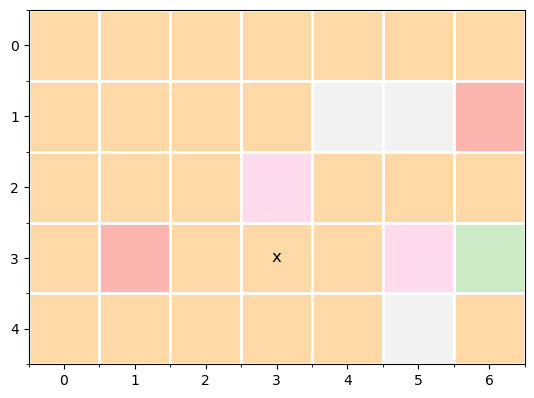

In [55]:
world = GridWorld((7, 5), (6, 3))
world.addSlider((5, 3), (4, 3))
world.addSlider((3, 2), (3, 1))
# important: add Walls after sliders!
world.addWall((5, 4))
world.addWall((5, 1))
world.addTrap((6, 1))
world.addWall((4, 1))
# world.addWall((0,3))
world.addTrap((1, 3))
# world.addWall((3,5))
# print(world.dynamics[(4,4)])
world.plot({world.getState(): "x"})


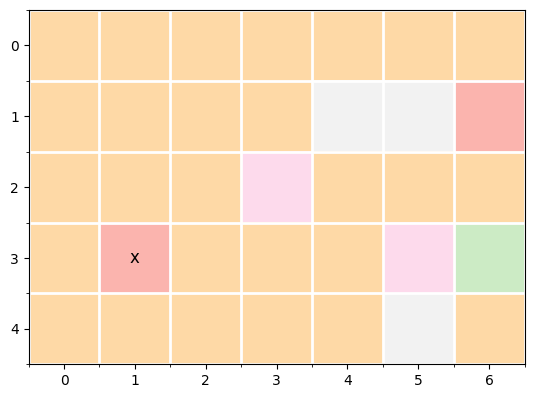

In [52]:
# test walk

import time
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output


# plt.show()

# def init():
world.reset()
# world.plot({world.getState(): "x"}, ax)
while not world.gameOver():
    # def update(i):
    # if world.gameOver():
    #    return
    act = naive_pi(world)
    print(act)
    world.step(act)
    clear_output()
    world.plot({world.getState(): "x"})
    time.sleep(.5)


# ani = FuncAnimation(fig, update, interval=50000, blit=True)

# ani.save('basic_animation.gif', fps=30)

# plt.show()


In [53]:
# sample and find MC approx. of V
def MC(epochs):
    V_aggregator = {}

    for i in range(epochs):
        world.reset()
        start = world.getState()
        reward = world.getReward(start)
        while not world.gameOver() and reward > -1:
            reward += world.step(naive_pi(world))

        if start in V_aggregator:
            V_aggregator[start].append(reward)
        else:
            V_aggregator[start] = [reward]

    for k, v in V_aggregator.items():
        V_aggregator[k] = np.mean(v)

    return V_aggregator


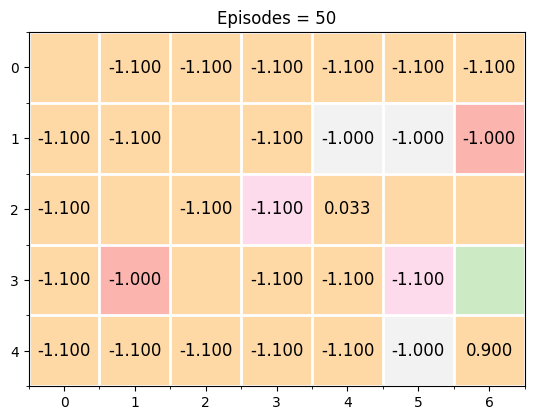

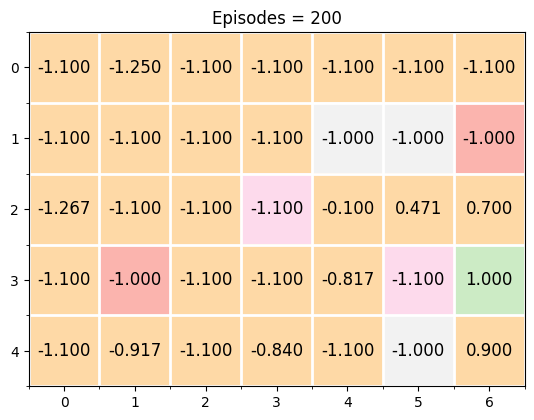

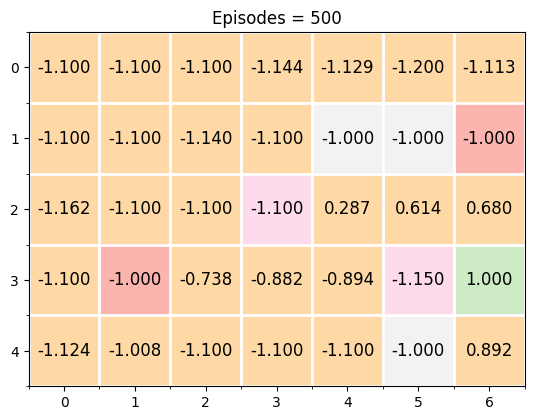

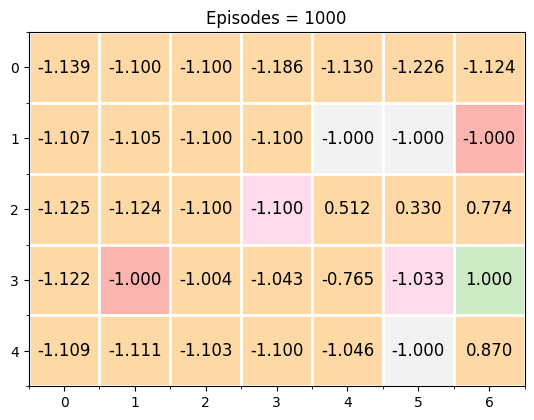

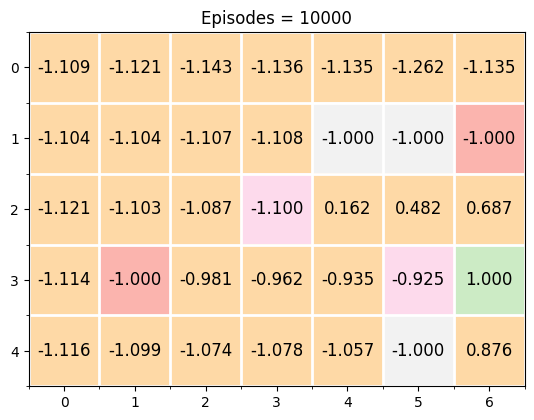

In [55]:
for i in [50, 200, 500, 1000, 10000]:
    world.plot(MC(i), title="Episodes = " + str(i))


In [278]:
# Homework 2: Implementing MC Policy Iteration with exploring starts


In [5]:
# Initialize random pi
import time
import copy

states = world.getStates()
actions = world.getActions()
vals = random.choices(actions, k=len(states))
pi = dict(zip(states, vals))

# Initialize Q randomly
Q = states
Q = dict(list(map(lambda s: (
    s, dict(list(map(lambda a: (a, random.uniform(-1, 1)), actions)))), Q)))

# Set return accumulator
Returns = states
Returns = dict(
    list(map(lambda s: (s, dict(list(map(lambda a: (a, []), actions)))), Returns)))

# Metrics
episode_returns = []
times = []

# main loop
episodes = 10000
max_steps = 20
gamma = 0.9

vis_total = 10  # how many total visualizations of the Q-Values do we want to capture?
# caution: for small # of episodes may yield duplicate values
Q_Record_Episodes = np.geomspace(1, episodes, vis_total).astype(int)
Q_Record = []

for episode in range(episodes):
    # choose random start
    world.reset()
    start_state = world.getState()  # start state automatically chosen randomly
    start_action = random.choice(actions)

    Record_steps = []  # list of rewards of episode
    Record_steps.append((start_state, start_action))
    Record_rewards = []
    Record_rewards.append(world.step(start_action))

    # create episode according to pi
    step_counter = 0
    while not world.gameOver() and step_counter <= max_steps:
        step_counter += 1
        action = pi[world.getState()]
        Record_steps.append((world.getState(), action))
        Record_rewards.append(world.step(action))

    # update metrics
    episode_returns.append(sum(Record_rewards))
    times.append(time.time())

    # update Q-value function and pi according to MC-Method
    G = 0
    while Record_steps:
        last_step = Record_steps.pop()
        last_reward = Record_rewards.pop()
        G = gamma*G + last_reward
        if last_step not in Record_steps:
            state, action = last_step
            Returns[state][action].append(G)
            Q[state][action] = np.mean(Returns[state][action])
            pi[state] = max(Q[state], key=Q[state].get)

    # update metrics 2
    if (episode in Q_Record_Episodes):
        Q_Record.append(copy.deepcopy(Q))


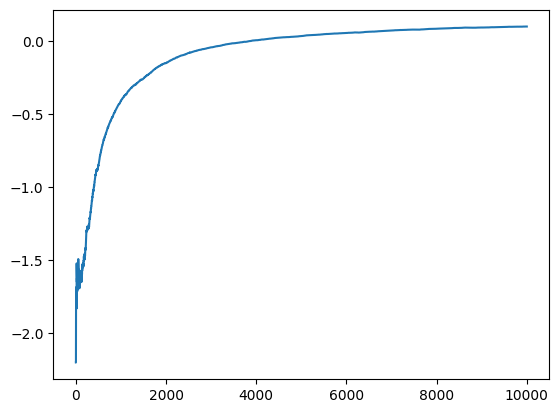

In [6]:
average_returns = [episode_returns[0]]
for ind, ret in enumerate(episode_returns[1:], 1):
    average_returns.append(((ind)*average_returns[-1] + ret)/(ind+1))

plt.plot(average_returns)
plt.show()


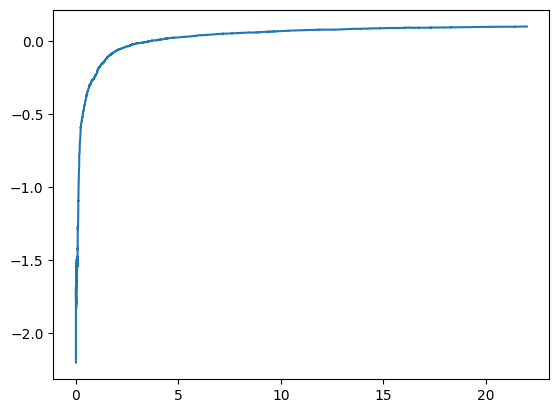

In [7]:
times = np.round(np.subtract(times, times[0]), decimals=4)
plt.plot(times, average_returns)
plt.show()


In [ ]:
# plot value function
Vals = {state: actions[pi[state]] for state, actions in Q.items()}
world.plot(Vals)


In [ ]:
# plot policy
Acts = {state: action_names[action] for state, action in pi.items()}
world.plot(Acts)


In [ ]:
for episode, record in zip(Q_Record_Episodes, Q_Record):
    world.plot_state_actions(record, title="Episode " + str(episode))


In [9]:
# HW 3

In [ ]:
MC_Q = Q_Record[4]

In [56]:
# SARSA

import time
import copy

states = world.getStates()
actions = world.getActions()

# Initialize Q randomly
# Q is a 2 level dict, that for a state and action gives the respective q value
# eg. Q[(1,1)][LEFT] = 0.4
Q = states
Q = dict(list(map(lambda s: (
    s, dict(list(map(lambda a: (a, random.uniform(-0.1, 0.1)), actions)))), Q)))
# set Q of the terminal state to 0
Q[world.getGoal()] = {LEFT: 0, RIGHT: 0, TOP: 0, DOWN: 0}


# Metrics
episode_returns = []
times = []

# main loop
episodes = 10000
max_steps = 20
gamma = 0.9
alpha = 0.5

vis_total = 10  # how many total visualizations of the Q-Values do we want to capture?
# caution: for small # of episodes may yield duplicate values
Q_Record_Episodes = np.geomspace(1, episodes, vis_total).astype(int)
Q_Record = []

for episode in range(episodes):
    # choose random start
    world.reset()
    start_state = world.getState()  # start state automatically chosen randomly

    # Metrics
    Record_steps = []  # list of rewards of episode
    Record_rewards = []

    action = max(Q[start_state], key=Q[start_state].get)
    state = world.getState()

    # do SARSA episode
    step_counter = 0
    while not world.gameOver() and step_counter <= max_steps:
        step_counter += 1
        
        # do step of episode
        reward = world.step(action)

        # update metrics
        Record_steps.append((state, action))
        Record_rewards.append(reward)

        # greedily compute new action
        new_state = world.getState()
        new_action = max(Q[new_state], key=Q[new_state].get)

        # 1 Step SARSA update
        Q[state][action] += alpha * (reward + gamma*Q[new_state][new_action] - Q[state][action])

        state = new_state
        action = new_action

    # update metrics
    episode_returns.append(sum(Record_rewards))
    times.append(time.time())

    # update metrics 2
    if (episode in Q_Record_Episodes):
        Q_Record.append(copy.deepcopy(Q))


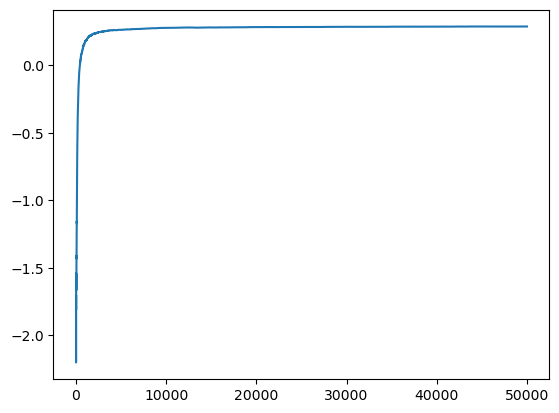

In [57]:
average_returns = [episode_returns[0]]
for ind, ret in enumerate(episode_returns[1:], 1):
    average_returns.append(((ind)*average_returns[-1] + ret)/(ind+1))

plt.plot(average_returns)
plt.show()

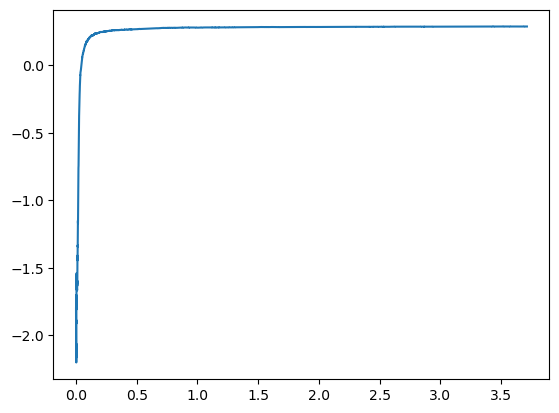

In [58]:
times = np.round(np.subtract(times, times[0]), decimals=4)
plt.plot(times, average_returns)
plt.show()

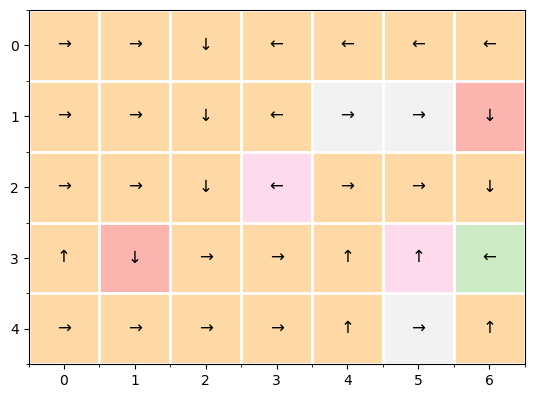

In [59]:
# plot policy
Acts = {state: action_names[max(actions, key=actions.get)] for state, actions in Q.items()}
world.plot(Acts)

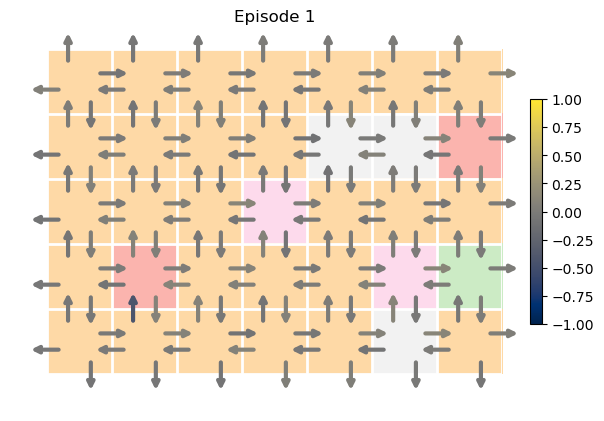

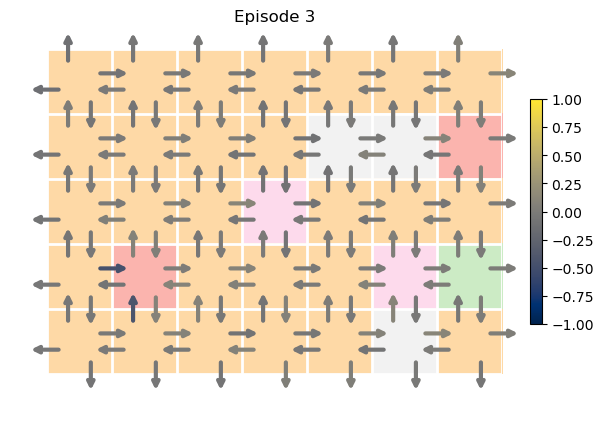

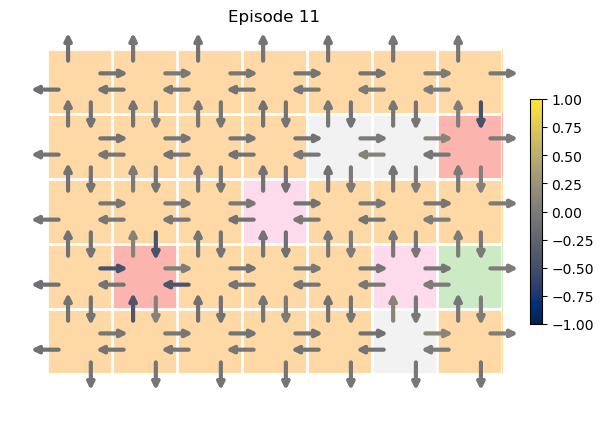

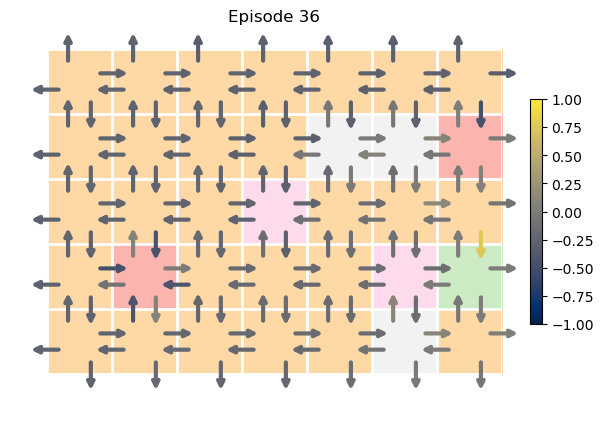

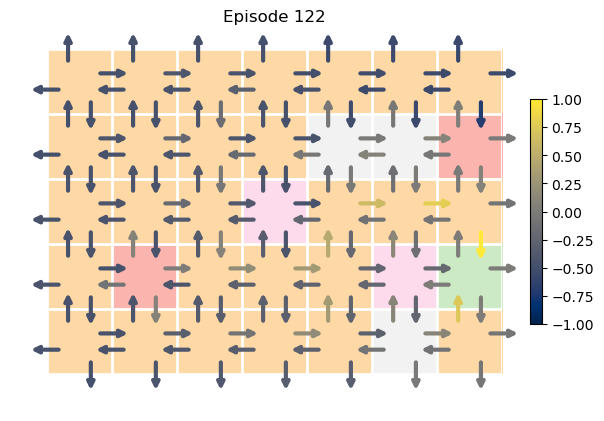

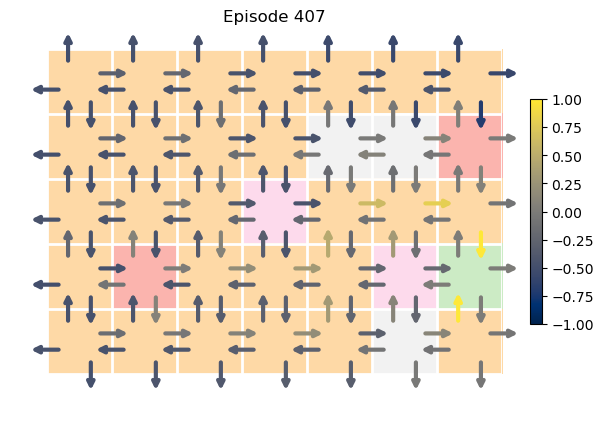

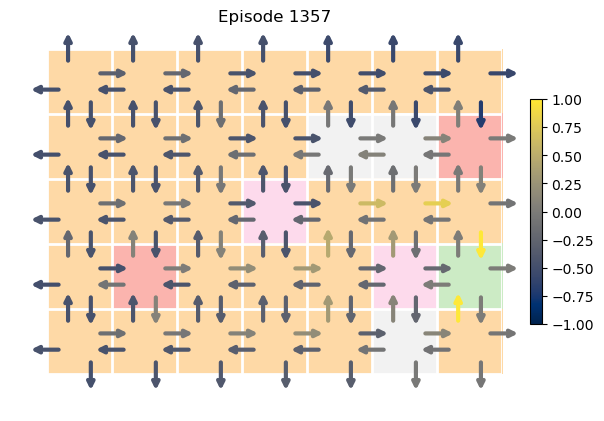

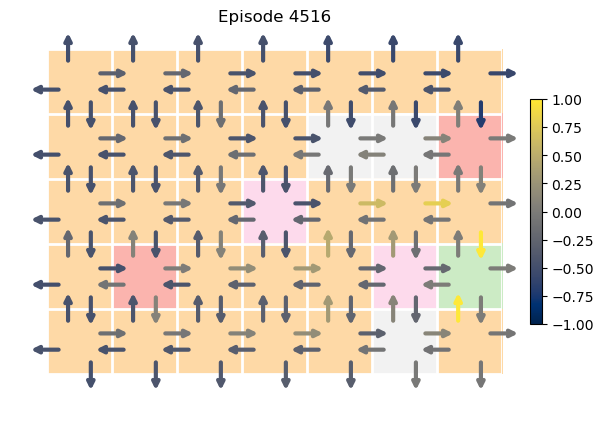

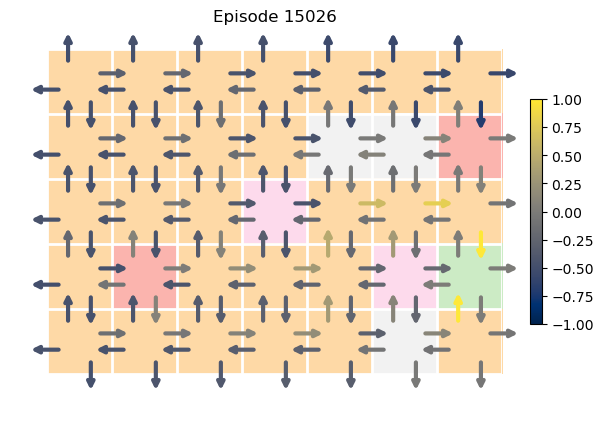

In [60]:
for episode, record in zip(Q_Record_Episodes, Q_Record):
    world.plot_state_actions(record, title="Episode " + str(episode))

In [ ]:
SARSA_Q = Q_Record[4]

interesting_state = (4,4)
